### Summary

The goal of this competition is to identify online auction bids that are placed by "robots", helping the site owners easily flag these users for removal from their site to prevent unfair auction activity

There are two datasets in this competition. One is a bidder dataset that includes a list of bidder information, including their id, payment account, and address. The other is a bid dataset that includes 7.6 million bids on different auctions. The bids in this dataset are all made by mobile devices. 

Label of a bidder indicating whether or not it is a robot. Value 1.0 indicates a robot, where value 0.0 indicates human. 

### For the bidder dataset

bidder_id – Unique identifier of a bidder.

payment_account – Payment account associated with a bidder. These are obfuscated to protect privacy. 

address – Mailing address of a bidder. These are obfuscated to protect privacy. 

outcome – Label of a bidder indicating whether or not it is a robot. Value 1.0 indicates a robot, where value 0.0 indicates human. 

The outcome was half hand labeled, half stats-based. There are two types of "bots" with different levels of proof:

1. Bidders who are identified as bots/fraudulent with clear proof. Their accounts were banned by the auction site.

2. Bidder who may have just started their business/clicks or their stats exceed from system wide average. There are no clear proof that they are bots. 

### Exploratory Data Analysis

In [363]:
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix, f1_score
import scikitplot as skplt
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
train = pd.read_csv('train.csv')
train.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [3]:
train.describe()

,outcome
count,2013.000000
mean,0.051167
std,0.220394
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [4]:
train.outcome.value_counts() # we see that target is only 5%, hence imbalanced, might need to do some upsampling here...

0.0    1910
1.0     103
Name: outcome, dtype: int64

In [5]:
test = pd.read_csv('test.csv')
test

,bidder_id,payment_account,address
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,a3d2de7675556553a5f08e4c88d2c228htx90,5d9fa1b71f992e7c7a106ce4b07a0a754le7c
1,a921612b85a1494456e74c09393ccb65ylp4y,a3d2de7675556553a5f08e4c88d2c228rs17i,a3d2de7675556553a5f08e4c88d2c228klidn
2,6b601e72a4d264dab9ace9d7b229b47479v6i,925381cce086b8cc9594eee1c77edf665zjpl,a3d2de7675556553a5f08e4c88d2c228aght0
3,eaf0ed0afc9689779417274b4791726cn5udi,a3d2de7675556553a5f08e4c88d2c228nclv5,b5714de1fd69d4a0d2e39d59e53fe9e15vwat
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,a3d2de7675556553a5f08e4c88d2c228dtdkd,c3b363a3c3b838d58c85acf0fc9964cb4pnfa
...,...,...,...
4695,bef56983ba78b2ee064443ae95972877jfkyd,0f235a6dfea5a5885d63968826b748b4q4dra,a98a4841db165de919d29cb49d0bc306cq21h
4696,4da45cc915c32d4368ac7e773d92d4affwqrr,9e0adf7481c422654d4d0a849e0e50abiumen,e23d9777cddc347de82d839b2e54b22ecopkp
4697,0d0e6220bf59ab9a0c5b5987fb2c34a9p33f9,7df4ebd184668b4257f740b11d4519afq7kr1,b650404e1ab5d177020221277c3e9306qegyl
4698,4981c32c54dde65b79dbc48fd9ab6457caqze,a3d2de7675556553a5f08e4c88d2c2284qlm0,9c35320088eaf32046a51a96ebb2e658i479u


### For the bid dataset

bid_id - unique id for this bid

bidder_id – Unique identifier of a bidder (same as the bidder_id used in train.csv and test.csv)

auction – Unique identifier of an auction

merchandise –  The category of the auction site campaign, which means the bidder might come to this site by way of searching for "home goods" but ended up bidding for "sporting goods" - and that leads to this field being "home goods". This categorical field could be a search term, or online advertisement. 

device – Phone model of a visitor

time - Time that the bid is made (transformed to protect privacy).

country - The country that the IP belongs to

ip – IP address of a bidder (obfuscated to protect privacy).

url - url where the bidder was referred from (obfuscated to protect privacy). 

In [6]:
bids = pd.read_csv('bids.csv')
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [7]:
bids.describe()

,bid_id,time
count,7.656334e+06,7.656334e+06
mean,3.828166e+06,9.697978e+15
std,2.210193e+06,5.250518e+13
min,0.000000e+00,9.631917e+15
25%,1.914083e+06,9.641139e+15
50%,3.828166e+06,9.700654e+15
75%,5.742250e+06,9.761744e+15
max,7.656333e+06,9.772885e+15


### Data Cleaning

In [8]:
train[train.isnull()].count() # no null values so not much processing needs to be done here

bidder_id          0
payment_account    0
address            0
outcome            0
dtype: int64

In [9]:
train.nunique() # looks like payment_account and address are un-insightful categorical values that we should drop

bidder_id          2013
payment_account    2013
address            2013
outcome               2
dtype: int64

In [281]:
train2 = train.drop(['payment_account', 'address'], axis=1)
train2.head()

,bidder_id,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0


In [282]:
test2 = test.drop(['payment_account', 'address'], axis=1)
test2.head()

,bidder_id
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7
1,a921612b85a1494456e74c09393ccb65ylp4y
2,6b601e72a4d264dab9ace9d7b229b47479v6i
3,eaf0ed0afc9689779417274b4791726cn5udi
4,cdecd8d02ed8c6037e38042c7745f688mx5sf


In [12]:
len(test)

4700

In [13]:
### Feature Engineering

In [14]:
bids[bids.isnull()].count() # wow no null values again

bid_id         0
bidder_id      0
auction        0
merchandise    0
device         0
time           0
country        0
ip             0
url            0
dtype: int64

Strategy
- label/count/target/catboost encode auction, merchandise, device, country, ip, time and url
- not sure what do to with time, maybe we could drop it for now?
- aggregate groupby bidder_id for count,mean, median, min, max: n_bids, n_auction, n_merchandise, n_countries
- dealing with imbalance
    - downsampling - but not much data in training set size
    - upsampling - imblearn + SMOTE
    - reframe as anomaly detection
    - use tree-based algorithms
    
    
### Feature Engineering
- the mean and median time between a user's bids
- the mean and median time between a user's bids for each auction
- the mean and median time between a user's bids from the previous bid for each auction
- ***the mean number of bids a user made per auction (DONE) ***
- the entropy for how many bids a user placed on each day of the week
- the means of the per-auction URL entropy and IP entropy for each user
- the maximum number of bids in a 20 min span
- ***the total number of bids placed by the user (DONE)***
- ***the average number of bids a user placed per referring URL (DONE)***
- the number of bids placed by the user on each of the three weekdays in the data
- the fraction of IPs used by a bidder which were also used by another user which was a bot

In [15]:
bids.nunique() # we can label encode auction, merchandise, device, country, ip and url - not sure about time?

bid_id         7656334
bidder_id         6614
auction          15051
merchandise         10
device            7351
time            776529
country            199
ip             2303991
url            1786351
dtype: int64

###  Mean and Median time between a user's bids

In [251]:
bid_times = bids[['bidder_id', 'time']].sort_values(['bidder_id', 'time'])
bid_times['time_diff'] = bid_times.time.diff()
bid_times = bid_times.groupby('bidder_id').apply(lambda x: x.iloc[1:, 1:])
bid_times

time     time_diff
bidder_id                                                                    
002d229ffb247009810828f648afc2ef593rb 1281311  9766744210526315  1.052632e+08
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o 6166636  9700605052631578  6.058642e+13
                                      7140567  9705974315789473  5.369263e+12
00486a11dff552c4bd7696265724ff81yeo9v 2599005  9632641157894736  4.631579e+09
                                      2750709  9633339684210526  6.985263e+11
...                                                         ...           ...
ffd62646d600b759a985d45918bd6f0431vmz 2334950  9772797315789473  2.105263e+08
                                      2336021  9772802947368421  5.631579e+09
                                      2337626  9772811421052631  8.473684e+09
                                      2344645  9772850052631578  3.863158e+10
                                      2350507  9772881631578947  3.157895e+10

[7649720 rows x 2 columns]

### Mean and Median time between a user's bids for each Auction

In [252]:
bid_times_auction = bids[['bidder_id', 'auction', 'time']].sort_values(['bidder_id', 'auction', 'time'])
bid_times_auction['time_diff'] = bid_times_auction.time.diff()
bid_times_auction = bid_times_auction.groupby(['bidder_id', 'auction']).apply(lambda x: x.iloc[1:, 1:])
bid_times_auction = bid_times_auction.rename(columns={'auction': 'auction2'})
bid_times_auction

auction2  \
bidder_id                             auction                     
002d229ffb247009810828f648afc2ef593rb 179     1281311       179   
00486a11dff552c4bd7696265724ff81yeo9v 639     5391258       639   
                                      2787    3302219      2787   
                                      8902    5049478      8902   
                                      19153   3786154     19153   
...                                                         ...   
ffd62646d600b759a985d45918bd6f0431vmz 5638    757041       5638   
                                              769173       5638   
                                      8494    513642       8494   
                                              518755       8494   
                                              660101       8494   

                                                                   time  \
bidder_id                             auction                             
002d229ffb247009810828f648afc2ef593rb 179     1281311  9766744210526315   
00486a11dff552c4bd7696265724ff81yeo9v 639     5391258  9696115947368421   
                                      2787    3302219  9636501894736842   
                                      8902    5049478  9644836894736842   
                                      19153   3786154  9638911421052631   
...                                                                 ...   
ffd62646d600b759a985d45918bd6f0431vmz 5638    757041   9763721842105263   
                                              769173   9763786052631578   
                                      8494    513642   9762168421052631   
                                              518755   9762202842105263   
                                              660101   9763126526315789   

                                                          time_diff  
bidder_id                             auction                        
002d229ffb247009810828f648afc2ef593rb 179     1281311  1.052632e+08  
00486a11dff552c4bd7696265724ff81yeo9v 639     5391258  3.373158e+11  
                                      2787    3302219  3.860737e+12  
                                      8902    5049478  1.734895e+12  
                                      19153   3786154  5.571737e+12  
...                                                             ...  
ffd62646d600b759a985d45918bd6f0431vmz 5638    757041   2.421053e+09  
                                              769173   6.421053e+10  
                                      8494    513642   4.694737e+10  
                                              518755   3.442105e+10  
                                              660101   9.236842e+11  

[7319334 rows x 3 columns]

### Mean and Median time between a user's bids from the previous bid for each Auction

In [253]:
bid_times_auction_any = bids[['bidder_id', 'auction', 'time']].sort_values(['auction', 'time'])
bid_times_auction_any['time_diff'] = bid_times_auction_any.time.diff()
bid_times_auction_any = bid_times_auction_any.groupby(['bidder_id', 'auction']).apply(lambda x: x.iloc[1:, 1:])
bid_times_auction_any = bid_times_auction_any.rename(columns={'auction': 'auction2'})
bid_times_auction_any

auction2  \
bidder_id                             auction                     
002d229ffb247009810828f648afc2ef593rb 179     1281311       179   
00486a11dff552c4bd7696265724ff81yeo9v 639     5391258       639   
                                      2787    3302219      2787   
                                      8902    5049478      8902   
                                      19153   3786154     19153   
...                                                         ...   
ffd62646d600b759a985d45918bd6f0431vmz 5638    757041       5638   
                                              769173       5638   
                                      8494    513642       8494   
                                              518755       8494   
                                              660101       8494   

                                                                   time  \
bidder_id                             auction                             
002d229ffb247009810828f648afc2ef593rb 179     1281311  9766744210526315   
00486a11dff552c4bd7696265724ff81yeo9v 639     5391258  9696115947368421   
                                      2787    3302219  9636501894736842   
                                      8902    5049478  9644836894736842   
                                      19153   3786154  9638911421052631   
...                                                                 ...   
ffd62646d600b759a985d45918bd6f0431vmz 5638    757041   9763721842105263   
                                              769173   9763786052631578   
                                      8494    513642   9762168421052631   
                                              518755   9762202842105263   
                                              660101   9763126526315789   

                                                          time_diff  
bidder_id                             auction                        
002d229ffb247009810828f648afc2ef593rb 179     1281311  1.052632e+08  
00486a11dff552c4bd7696265724ff81yeo9v 639     5391258  4.263158e+09  
                                      2787    3302219  2.052632e+09  
                                      8902    5049478  2.631579e+08  
                                      19153   3786154  5.789474e+08  
...                                                             ...  
ffd62646d600b759a985d45918bd6f0431vmz 5638    757041   5.263158e+07  
                                              769173   4.736842e+08  
                                      8494    513642   5.789474e+08  
                                              518755   2.631579e+08  
                                              660101   1.789474e+09  

[7319334 rows x 3 columns]

### Aggregating Time Diff Values

In [278]:
agg_bid_times = pd.DataFrame(data={"bidder_id": bids.bidder_id.unique()}, index=bids.bidder_id.unique())
agg_bid_times['mean_time_btw_bids'] = bid_times.groupby('bidder_id').mean().time_diff
agg_bid_times['median_time_btw_bids'] = bid_times.groupby('bidder_id').median().time_diff
agg_bid_times['mean_time_btw_bids_auction'] = bid_times_auction.groupby(['bidder_id', 'auction2']).mean().groupby(['bidder_id']).mean().time_diff
agg_bid_times['median_time_btw_bids_auction'] = bid_times_auction.groupby(['bidder_id', 'auction2']).median().groupby(['bidder_id']).median().time_diff
agg_bid_times['mean_time_btw_bids_auction_any'] = bid_times_auction_any.groupby(['bidder_id', 'auction2']).mean().groupby(['bidder_id']).mean().time_diff
agg_bid_times['mean_time_btw_bids_auction_any'] = bid_times_auction_any.groupby(['bidder_id', 'auction2']).median().groupby(['bidder_id']).median().time_diff
agg_bid_times = agg_bid_times.fillna(0)
agg_bid_times


,bidder_id,mean_time_btw_bids,median_time_btw_bids,mean_time_btw_bids_auction,median_time_btw_bids_auction,mean_time_btw_bids_auction_any
8dac2b259fd1c6d1120e519fb1ac14fbqvax8,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,2.181642e+08,105263158.0,8.898879e+11,2.033947e+11,5.723684e+09
668d393e858e8126275433046bbd35c6tywop,668d393e858e8126275433046bbd35c6tywop,6.825358e+08,421052631.0,1.218763e+12,3.524474e+11,6.815789e+09
aa5f360084278b35d746fa6af3a7a1a5ra3xe,aa5f360084278b35d746fa6af3a7a1a5ra3xe,1.293853e+08,52631579.0,5.750279e+11,6.092105e+10,4.578947e+09
3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,1.245161e+09,736842106.0,1.466647e+12,3.362500e+11,3.052632e+09
8393c48eaf4b8fa96886edc7cf27b372dsibi,8393c48eaf4b8fa96886edc7cf27b372dsibi,1.058529e+09,631578947.0,1.418962e+12,3.426579e+11,3.105263e+09
...,...,...,...,...,...,...
57baadea0359cccd55d6e3b530b021f13umk8,57baadea0359cccd55d6e3b530b021f13umk8,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
91c749114e26abdb9a4536169f9b4580huern,91c749114e26abdb9a4536169f9b4580huern,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
a06311ea45de34bf667b79a92d13c764i6aiy,a06311ea45de34bf667b79a92d13c764i6aiy,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
dfb23124fba16b7778f65c1c8d091f949jz0k,dfb23124fba16b7778f65c1c8d091f949jz0k,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00


In [283]:
train2 = train2.merge(agg_bid_times, how='left', on='bidder_id')
train2

,bidder_id,outcome,mean_time_btw_bids,median_time_btw_bids,mean_time_btw_bids_auction,median_time_btw_bids_auction,mean_time_btw_bids_auction_any
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,5.711121e+11,3.458421e+11,8.323474e+11,2.837368e+11,7.105263e+08
1,624f258b49e77713fc34034560f93fb3hu3jo,0.0,3.233579e+12,3.233579e+12,3.233579e+12,3.233579e+12,2.631579e+07
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0,2.379000e+12,2.532053e+12,0.000000e+00,0.000000e+00,0.000000e+00
3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0,7.777888e+10,1.368421e+10,1.442109e+12,9.236842e+10,8.947368e+08
...,...,...,...,...,...,...,...
2008,369515b3af4f8ca582f90271d30b14b6r52aw,0.0,2.099162e+12,6.842105e+08,9.551696e+11,5.628421e+11,1.031579e+10
2009,f939c17ffc7c39ac9b35b69e5e75179fv9pe2,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2010,c806dbb2decba0ed3c4ff5e2e60a74c2wjvbl,0.0,9.798474e+12,9.798474e+12,9.798474e+12,9.798474e+12,0.000000e+00
2011,0381a69b7a061e9ace2798fd48f1f537mgq57,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [284]:
test2 = test2.merge(agg_bid_times, how='left', on='bidder_id')
test2

,bidder_id,mean_time_btw_bids,median_time_btw_bids,mean_time_btw_bids_auction,median_time_btw_bids_auction,mean_time_btw_bids_auction_any
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,2.340789e+13,5.781053e+12,4.545421e+12,4.545421e+12,5.263158e+07
1,a921612b85a1494456e74c09393ccb65ylp4y,3.800103e+13,3.800103e+13,1.052632e+08,1.052632e+08,1.052632e+08
2,6b601e72a4d264dab9ace9d7b229b47479v6i,1.819079e+10,2.315789e+09,9.542105e+10,1.952632e+10,2.157895e+09
3,eaf0ed0afc9689779417274b4791726cn5udi,5.205553e+11,1.046842e+11,1.966770e+13,1.937289e+12,2.868421e+09
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,2.988541e+11,8.131579e+09,2.162930e+12,1.607632e+12,1.026316e+10
...,...,...,...,...,...,...
4695,bef56983ba78b2ee064443ae95972877jfkyd,6.852262e+10,0.000000e+00,1.211883e+11,5.000000e+09,1.631579e+09
4696,4da45cc915c32d4368ac7e773d92d4affwqrr,2.059579e+11,9.584211e+10,1.628025e+12,1.048553e+12,2.921053e+09
4697,0d0e6220bf59ab9a0c5b5987fb2c34a9p33f9,3.576290e+10,6.526316e+09,1.077241e+13,1.501500e+12,4.973684e+09
4698,4981c32c54dde65b79dbc48fd9ab6457caqze,2.285079e+12,1.519737e+12,0.000000e+00,0.000000e+00,0.000000e+00


In [16]:
# Count encoding replaces each categorical value with the number of times it appears in the dataset.
bids2 = bids
cat_features = ['auction', 'merchandise', 'device', 'time', 'country', 'ip', 'url']
count_enc = ce.CountEncoder()
bids2[cat_features] = count_enc.fit_transform(bids[cat_features])
bids2

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,3331,1902058,34287,9759243157894736,318103,309,3499409
1,1,668d393e858e8126275433046bbd35c6tywop,9376,99181,22591,9759243157894736,1788731,6313,11
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,310,1224234,171584,9759243157894736,9704,2,3499409
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,208926,1902058,706573,9759243157894736,1788731,3,3499409
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,208926,1902058,78439,9759243157894736,1788731,1,3499409
...,...,...,...,...,...,...,...,...,...
7656329,7656329,626159dd6f2228ede002d9f9340f75b7puk8d,65,1902058,38395,9709222052631578,140288,5,1
7656330,7656330,a318ea333ceee1ba39a494476386136a826dv,6899,2126587,6385,9709222052631578,52012,198,1
7656331,7656331,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,19038,1855207,50342,9709222052631578,297942,1,3
7656332,7656332,d4bd412590f5106b9d887a43c51b254eldo4f,583,1902058,5672,9709222052631578,216799,1356,3045


In [17]:
# group by bidder_id - number of each column --> in this case since all categorical so cant generate numeric stats?
def aggregate_features(data, key, cols, name=''):
    agg = data.groupby(cols).count().groupby(key)[data.columns[0]]
    df = pd.DataFrame()
    df['min_' + name] = agg.min()
    df['max_' + name] = agg.max()
    df['mean_' + name] = agg.mean()
    df['median_' + name] = agg.median()
    return df

def generate_features(df, df_agg, cols, names, key):
    df = df.merge(pd.DataFrame(data={'total_counts': df_agg.groupby('bidder_id').count().iloc[:, 0]}), how='left', on='bidder_id')
    for col, name in zip(cols, names):
        df = df.merge(aggregate_features(df_agg, key, col, name), how='left', on=key)
    return df

In [285]:
# compute mean, median, min, max number of bids per user per auction / merchandise / device / URL
cols = [['bidder_id', 'auction'], ['bidder_id', 'merchandise'], ['bidder_id', 'device'], ['bidder_id', 'url']]
names = ['bids_per_auction', 'bids_per_merchandise', 'bids_per_device', 'bids_per_url']
train3 = generate_features(train2, bids2, cols, names, key='bidder_id')
train3

,bidder_id,outcome,mean_time_btw_bids,median_time_btw_bids,mean_time_btw_bids_auction,median_time_btw_bids_auction,mean_time_btw_bids_auction_any,total_counts,min_bids_per_auction,max_bids_per_auction,...,mean_bids_per_merchandise,median_bids_per_merchandise,min_bids_per_device,max_bids_per_device,mean_bids_per_device,median_bids_per_device,min_bids_per_url,max_bids_per_url,mean_bids_per_url,median_bids_per_url
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,5.711121e+11,3.458421e+11,8.323474e+11,2.837368e+11,7.105263e+08,24.0,1.0,3.0,...,24.0,24.0,1.0,6.0,1.714286,1.0,24.0,24.0,24.0,24.0
1,624f258b49e77713fc34034560f93fb3hu3jo,0.0,3.233579e+12,3.233579e+12,3.233579e+12,3.233579e+12,2.631579e+07,3.0,3.0,3.0,...,3.0,3.0,1.0,2.0,1.500000,1.5,1.0,2.0,1.5,1.5
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0,2.379000e+12,2.532053e+12,0.000000e+00,0.000000e+00,0.000000e+00,4.0,1.0,1.0,...,4.0,4.0,1.0,3.0,2.000000,2.0,1.0,3.0,2.0,2.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0,7.777888e+10,1.368421e+10,1.442109e+12,9.236842e+10,8.947368e+08,155.0,1.0,38.0,...,155.0,155.0,1.0,19.0,2.924528,1.0,3.0,80.0,31.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,369515b3af4f8ca582f90271d30b14b6r52aw,0.0,2.099162e+12,6.842105e+08,9.551696e+11,5.628421e+11,1.031579e+10,36.0,1.0,4.0,...,36.0,36.0,1.0,33.0,9.000000,1.0,3.0,33.0,18.0,18.0
2009,f939c17ffc7c39ac9b35b69e5e75179fv9pe2,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0
2010,c806dbb2decba0ed3c4ff5e2e60a74c2wjvbl,0.0,9.798474e+12,9.798474e+12,9.798474e+12,9.798474e+12,0.000000e+00,2.0,2.0,2.0,...,2.0,2.0,1.0,1.0,1.000000,1.0,2.0,2.0,2.0,2.0
2011,0381a69b7a061e9ace2798fd48f1f537mgq57,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0


In [287]:
test3 = generate_features(test2, bids2, cols, names, key='bidder_id')
test3

,bidder_id,mean_time_btw_bids,median_time_btw_bids,mean_time_btw_bids_auction,median_time_btw_bids_auction,mean_time_btw_bids_auction_any,total_counts,min_bids_per_auction,max_bids_per_auction,mean_bids_per_auction,...,mean_bids_per_merchandise,median_bids_per_merchandise,min_bids_per_device,max_bids_per_device,mean_bids_per_device,median_bids_per_device,min_bids_per_url,max_bids_per_url,mean_bids_per_url,median_bids_per_url
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,2.340789e+13,5.781053e+12,4.545421e+12,4.545421e+12,5.263158e+07,4.0,1.0,2.0,1.333333,...,4.0,4.0,1.0,3.0,2.000000,2.0,2.0,2.0,2.000000,2.0
1,a921612b85a1494456e74c09393ccb65ylp4y,3.800103e+13,3.800103e+13,1.052632e+08,1.052632e+08,1.052632e+08,3.0,1.0,2.0,1.500000,...,3.0,3.0,1.0,1.0,1.000000,1.0,3.0,3.0,3.000000,3.0
2,6b601e72a4d264dab9ace9d7b229b47479v6i,1.819079e+10,2.315789e+09,9.542105e+10,1.952632e+10,2.157895e+09,17.0,1.0,2.0,1.214286,...,17.0,17.0,2.0,7.0,4.250000,4.0,4.0,13.0,8.500000,8.5
3,eaf0ed0afc9689779417274b4791726cn5udi,5.205553e+11,1.046842e+11,1.966770e+13,1.937289e+12,2.868421e+09,148.0,1.0,15.0,1.681818,...,148.0,148.0,1.0,20.0,1.850000,1.0,1.0,70.0,29.600000,8.0
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,2.988541e+11,8.131579e+09,2.162930e+12,1.607632e+12,1.026316e+10,23.0,1.0,2.0,1.150000,...,23.0,23.0,1.0,2.0,1.352941,1.0,23.0,23.0,23.000000,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4695,bef56983ba78b2ee064443ae95972877jfkyd,6.852262e+10,0.000000e+00,1.211883e+11,5.000000e+09,1.631579e+09,983.0,1.0,86.0,24.575000,...,983.0,983.0,3.0,421.0,109.222222,95.0,1.0,734.0,245.750000,124.0
4696,4da45cc915c32d4368ac7e773d92d4affwqrr,2.059579e+11,9.584211e+10,1.628025e+12,1.048553e+12,2.921053e+09,66.0,1.0,16.0,2.062500,...,66.0,66.0,1.0,22.0,2.275862,1.0,3.0,32.0,11.000000,9.0
4697,0d0e6220bf59ab9a0c5b5987fb2c34a9p33f9,3.576290e+10,6.526316e+09,1.077241e+13,1.501500e+12,4.973684e+09,2162.0,1.0,115.0,6.194842,...,2162.0,2162.0,1.0,349.0,5.843243,2.0,5.0,809.0,69.741935,16.0
4698,4981c32c54dde65b79dbc48fd9ab6457caqze,2.285079e+12,1.519737e+12,0.000000e+00,0.000000e+00,0.000000e+00,5.0,1.0,1.0,1.000000,...,5.0,5.0,1.0,2.0,1.250000,1.0,2.0,3.0,2.500000,2.5


### Model Building

In [288]:
Y = train3.outcome
X = train3.drop(['outcome', 'bidder_id'], axis=1)
x_test = test3.drop(['bidder_id'], axis=1)
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2)
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
xgb.score(x_valid, y_valid)

0.9553349875930521

In [289]:
pred = pd.DataFrame(data={'bidder_id': test.bidder_id, 'prediction': xgb.predict(x_test)}).set_index('bidder_id')
pred

,prediction
bidder_id,
49bb5a3c944b8fc337981cc7a9ccae41u31d7,0.0
a921612b85a1494456e74c09393ccb65ylp4y,0.0
6b601e72a4d264dab9ace9d7b229b47479v6i,0.0
eaf0ed0afc9689779417274b4791726cn5udi,0.0
cdecd8d02ed8c6037e38042c7745f688mx5sf,0.0
...,...
bef56983ba78b2ee064443ae95972877jfkyd,1.0
4da45cc915c32d4368ac7e773d92d4affwqrr,0.0
0d0e6220bf59ab9a0c5b5987fb2c34a9p33f9,0.0


In [290]:
pred.to_csv('predictions.csv') # score = 0.65

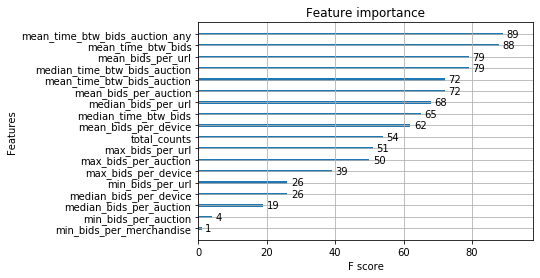

In [291]:
plot_importance(xgb)

### TO DO
- plot confusion matrix (DONE)
- evaluate using AUC/ROC and other scoring metrics (DONE)
- upsampling 
- grid search
- k-fold cross validation
- try different models

### AUC-ROC Curve & Confusion Matrix

From the confusion matrix, we can see that the model is excellent at predicting human bidders (class=0) with an accuracy of 98% however it fares much worse when predicting bots (class=1) at only 62% accuracy. 

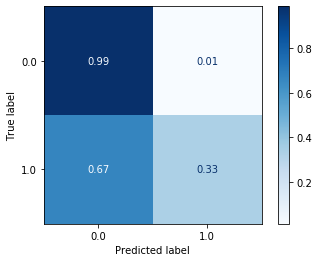

In [292]:
plot_confusion_matrix(xgb, x_valid, y_valid, cmap=plt.cm.Blues, normalize='true')

For any classification problem, it is also recommended to use the AUC-ROC probability curve to measure how well a classifier is able to distinguish between classes. The higher the AUC, better the model is at predicting humans vs bots, with less error. The ROC curve is plotted with True Positive Rate (TPR) against the False Positive Rate (FPR). Here we see that the macro average seems pretty good at 0.91, with the max being 1.

0.6614310645724257


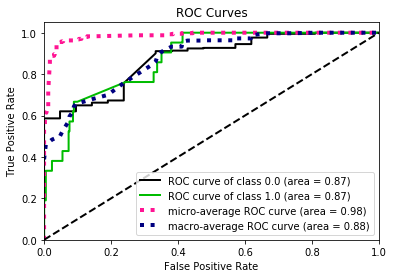

In [293]:
y_proba = xgb.predict_proba(x_valid)
y_pred = xgb.predict(x_valid)
skplt.metrics.plot_roc(y_valid, y_proba)
print(roc_auc_score(y_valid, y_pred))

However, due to class imblance, the true measure of performance is predicting the minority class (bots) instead of the majority (humans). Hence we should plot a precision-recall curve for different thresholds, where:

- Precision (P) = True Positives / (True Positives + False Positives)

- Recall (R) = True Positives / (True Positives + False Negatives)

From this , we can see that the precision-recall of class=1 (bots) is only 0.588. This implies that our model is merely predicting most classes to be humans, and is not actually very accurate at predicting bots. We can further use another metric F-Measure / F1 score that calculates the harmonic mean of the precision and recall.

Since our model has a high rate of false negatives because we are predicting bots as humans, the recall value is lower, and hence the F1-Score captures that. This makes precision-recall and a plot of precision vs. recall and summary measures useful tools for binary classification problems that have an imbalance in the observations for each class. Hence we can see that our mode is not performing well due to the class imbalance.

- F1-Score = 2 * (P * R) / (P + R)

/Users/pangshengwei/anaconda3/envs/datakind/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


0.43749999999999994


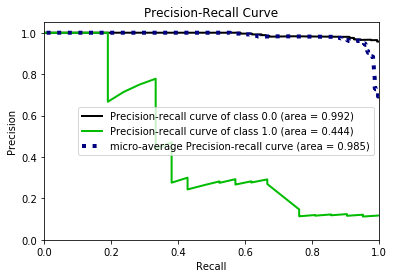

In [294]:
skplt.metrics.plot_precision_recall_curve(y_valid, y_proba)
print(f1_score(y_valid, y_pred))

### Minority Upsampling (SMOTE)

We could upsample the minority class by simply duplicating rows - this can balance the class distribution but does not provide any additional information to the model. A better approach is to synthesize new examples using the Synthetic Minority Oversampling Technique, or SMOTE. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. The approach is effective because new synthetic examples from the minority class are created that are plausible, that is, are relatively close in feature space to existing examples from the minority class. 

In [355]:
sm = SMOTE(sampling_strategy=1)
X_res, Y_res = sm.fit_resample(X2, Y)

Here we can see that 

In [356]:
Y.value_counts() 

0.0    1910
1.0     103
Name: outcome, dtype: int64

In [357]:
Y_res.value_counts() 

1.0    1910
0.0    1910
Name: outcome, dtype: int64

In [358]:
X

,mean_time_btw_bids,median_time_btw_bids,mean_time_btw_bids_auction,median_time_btw_bids_auction,mean_time_btw_bids_auction_any,total_counts,min_bids_per_auction,max_bids_per_auction,mean_bids_per_auction,median_bids_per_auction,...,mean_bids_per_merchandise,median_bids_per_merchandise,min_bids_per_device,max_bids_per_device,mean_bids_per_device,median_bids_per_device,min_bids_per_url,max_bids_per_url,mean_bids_per_url,median_bids_per_url
0,5.711121e+11,3.458421e+11,8.323474e+11,2.837368e+11,7.105263e+08,24.0,1.0,3.0,1.333333,1.0,...,24.0,24.0,1.0,6.0,1.714286,1.0,24.0,24.0,24.0,24.0
1,3.233579e+12,3.233579e+12,3.233579e+12,3.233579e+12,2.631579e+07,3.0,3.0,3.0,3.000000,3.0,...,3.0,3.0,1.0,2.0,1.500000,1.5,1.0,2.0,1.5,1.5
2,2.379000e+12,2.532053e+12,0.000000e+00,0.000000e+00,0.000000e+00,4.0,1.0,1.0,1.000000,1.0,...,4.0,4.0,1.0,3.0,2.000000,2.0,1.0,3.0,2.0,2.0
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000,1.0,...,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0
4,7.777888e+10,1.368421e+10,1.442109e+12,9.236842e+10,8.947368e+08,155.0,1.0,38.0,6.739130,2.0,...,155.0,155.0,1.0,19.0,2.924528,1.0,3.0,80.0,31.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,2.099162e+12,6.842105e+08,9.551696e+11,5.628421e+11,1.031579e+10,36.0,1.0,4.0,1.440000,1.0,...,36.0,36.0,1.0,33.0,9.000000,1.0,3.0,33.0,18.0,18.0
2009,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000,1.0,...,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0
2010,9.798474e+12,9.798474e+12,9.798474e+12,9.798474e+12,0.000000e+00,2.0,2.0,2.0,2.000000,2.0,...,2.0,2.0,1.0,1.0,1.000000,1.0,2.0,2.0,2.0,2.0
2011,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000,1.0,...,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0


In [359]:
X_res

,mean_time_btw_bids,median_time_btw_bids,mean_time_btw_bids_auction,median_time_btw_bids_auction,mean_time_btw_bids_auction_any,total_counts,min_bids_per_auction,max_bids_per_auction,mean_bids_per_auction,median_bids_per_auction,...,mean_bids_per_merchandise,median_bids_per_merchandise,min_bids_per_device,max_bids_per_device,mean_bids_per_device,median_bids_per_device,min_bids_per_url,max_bids_per_url,mean_bids_per_url,median_bids_per_url
0,5.711121e+11,3.458421e+11,8.323474e+11,2.837368e+11,7.105263e+08,24.000000,1.0,3.000000,1.333333,1.000000,...,24.000000,24.000000,1.0,6.000000,1.714286,1.000000,24.000000,24.000000,24.000000,24.000000
1,3.233579e+12,3.233579e+12,3.233579e+12,3.233579e+12,2.631579e+07,3.000000,3.0,3.000000,3.000000,3.000000,...,3.000000,3.000000,1.0,2.000000,1.500000,1.500000,1.000000,2.000000,1.500000,1.500000
2,2.379000e+12,2.532053e+12,0.000000e+00,0.000000e+00,0.000000e+00,4.000000,1.0,1.000000,1.000000,1.000000,...,4.000000,4.000000,1.0,3.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,7.777888e+10,1.368421e+10,1.442109e+12,9.236842e+10,8.947368e+08,155.000000,1.0,38.000000,6.739130,2.000000,...,155.000000,155.000000,1.0,19.000000,2.924528,1.000000,3.000000,80.000000,31.000000,13.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3815,5.142119e+08,2.912592e+08,9.611197e+11,2.051643e+11,5.328798e+09,28634.351430,1.0,1744.896720,62.087728,12.807787,...,28634.351430,28634.351430,1.0,2298.140368,41.546310,8.871858,1.106785,25197.829868,572.348930,20.023245
3816,2.055991e+09,5.243427e+08,1.381741e+12,2.934923e+11,4.890088e+09,7041.795812,1.0,687.696332,35.702327,4.495314,...,7041.795812,7041.795812,1.0,2709.570732,20.874181,2.000000,10.084348,5907.746590,719.167108,216.996236
3817,3.852147e+10,5.911799e+09,7.793730e+12,7.666800e+11,3.708001e+09,2028.065017,1.0,382.219383,16.659215,2.000000,...,2028.065017,2028.065017,1.0,846.722202,84.708449,15.528344,1.000000,2024.102808,676.021672,2.962209
3818,1.424228e+10,8.511828e+09,2.197185e+12,9.191070e+11,4.797755e+09,1025.170944,1.0,786.669716,10.373015,1.267872,...,1025.170944,1025.170944,1.0,193.694339,6.263891,1.732128,5.392769,663.549728,92.607643,25.338950


### Perform Grid Search with Stratified K-Fold Cross Validation

In [405]:
x_train, x_valid, y_train, y_valid = train_test_split(X2, Y, test_size=0.2)
params = {'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [10, 30, 50], 'n_estimators': [100, 200, 500]}
skcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model = GridSearchCV(XGBClassifier(), params, n_jobs=5, cv=skcv, scoring='f1_macro', verbose=2, refit=True)
model.fit(x_train, y_train)

Fitting 30 folds for each of 27 candidates, totalling 810 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   43.4s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done 810 out of 810 | elapsed:  3.8min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_c...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
       

In [406]:
best_params = model.best_params_
print(best_params)
model.score(x_valid, y_valid)

{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 500}


0.7709691438504997

0.716031746031746


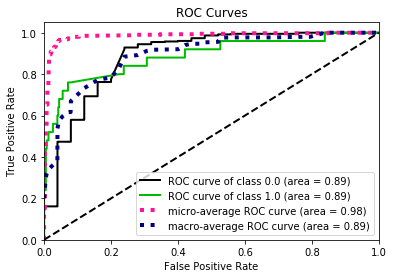

In [407]:
y_proba = model.predict_proba(x_valid)
y_pred = model.predict(x_valid)
skplt.metrics.plot_roc(y_valid, y_proba)
print(roc_auc_score(y_valid, y_pred))

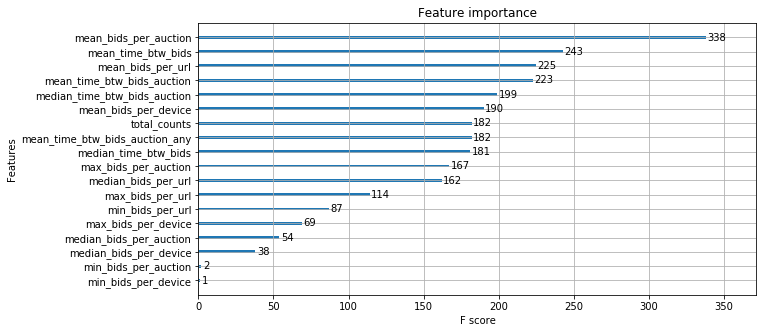

In [408]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(model.best_estimator_, ax=ax)

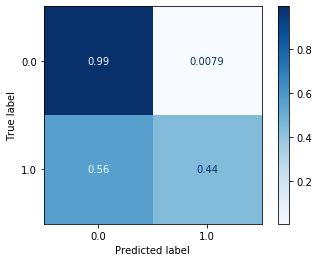

In [409]:
plot_confusion_matrix(model, x_valid, y_valid, cmap=plt.cm.Blues, normalize='true')

/Users/pangshengwei/anaconda3/envs/datakind/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


0.5641025641025641


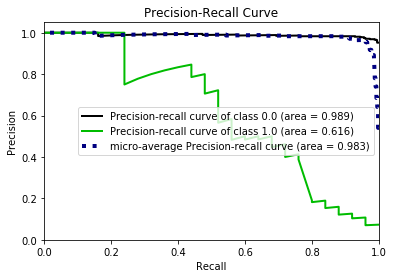

In [410]:
skplt.metrics.plot_precision_recall_curve(y_valid, y_proba)
print(f1_score(y_valid, y_pred))

In [ ]:
smote = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
xgb = XGBClassifier()
skcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

X2 = X.fillna(X.mean())
steps = [('over', smote), ('under', under), ('model', xgb)]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgb.fit(X2, Y), ax=ax)
#auc_roc_scores = cross_val_score(pipeline, X2, Y, scoring='roc_auc', cv=cv, n_jobs=1)
#print('Mean ROC AUC: %.3f' % np.mean(auc_roc_scores))
#f1_scores = cross_val_score(pipeline, X2, Y, scoring='f1_macro', cv=cv, n_jobs=1)
#print('Mean F1: %.3f' % np.mean(f1_scores))

In [411]:
model.fit(X2, Y)
pred = model.predict(x_test, y_test)

Fitting 30 folds for each of 27 candidates, totalling 810 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    9.3s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   58.4s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 810 out of 810 | elapsed: 20.1min finished


NameError: name 'y_test' is not defined